In [1]:
import os
import sys
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.pyplot as plt
from matplotlib import cm 
from matplotlib.ticker import LinearLocator, FormatStrFormatter 
import numpy as np 
from random import random, seed
import functions as fx
import sklearn.model_selection as sklm
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import  train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.utils import resample
from imageio import imread

In [2]:
# Where to save the figures and data files
PROJECT_ROOT_DIR = "/Users/endriasa/Projects/FYS4155/Project-1/Figures"
FIGURE_ID = "Figures"
DATA_ID = "DataFiles/"

if not os.path.exists(PROJECT_ROOT_DIR):
    os.mkdir(PROJECT_ROOT_DIR)

if not os.path.exists(FIGURE_ID):
    os.makedirs(FIGURE_ID)

if not os.path.exists(DATA_ID):
    os.makedirs(DATA_ID)

def image_path(fig_id):
    return os.path.join(FIGURE_ID, fig_id)

def data_path(dat_id):
    return os.path.join(DATA_ID, dat_id)

def save_fig(fig_id):
    plt.savefig(image_path(fig_id) + "_Terrain.png", dpi=100,pad_inches=0.0,transparent=False, bbox_inches='tight',format='png')

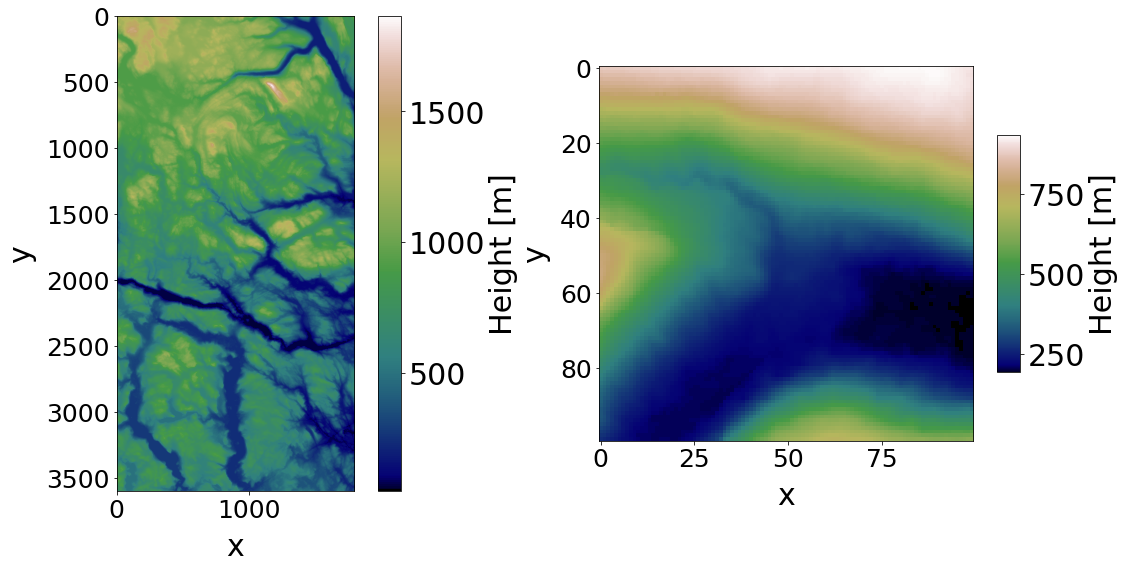

In [3]:
# Load the terrain
terrain_data = imread('SRTM_data_Norway_1.tif')
terrain_n = terrain_data[200:300,1300:1400]

# Plot the surfaces
fig  = plt.figure(figsize=(16, 8))
ax   = fig.add_subplot(1, 2, 1)
surf = ax.imshow(terrain_data, cmap='gist_earth')
ax.tick_params(axis='both', which='major', labelsize=25)
plt.xlabel('x', fontsize = 30,labelpad=10)
plt.ylabel('y', fontsize = 30,labelpad=10)
cbar=fig.colorbar(surf)
cbar.ax.set_ylabel('Height [m]', fontsize = 30)
cbar.ax.tick_params(labelsize=30)
fig.tight_layout()

# Show the terrain
ax   = fig.add_subplot(1, 2, 2)
surf = ax.imshow(terrain_n, cmap='gist_earth')
ax.tick_params(axis='both', which='major', labelsize=25)
plt.xlabel('x', fontsize = 30,labelpad=10)
plt.ylabel('y', fontsize = 30,labelpad=10)
cbar=fig.colorbar(surf,shrink=0.5, aspect=10)
cbar.ax.set_ylabel('Height [m]', fontsize = 30)
cbar.ax.tick_params(labelsize=30)
fig.tight_layout()
save_fig('Input_data')
plt.show()

In [48]:
print(terrain_data.min())
print(terrain_data.max())
print(terrain_data.mean())
print(terrain_data.std())

50
1865
703.0221301658911
303.4943496648173


# Model Selection by K-fold Cross Validation (OLS)

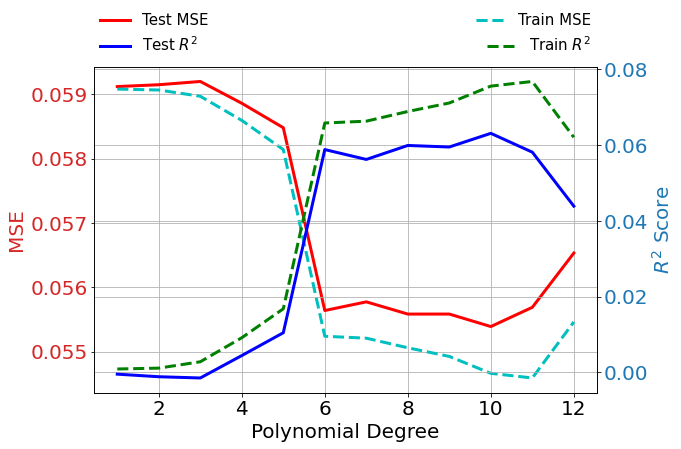

In [56]:
# Maximum polynomial order for generating the design matrix
maxpower = 12
k        = 5

np.random.seed(2020)
# subselecting the data, normalizing, creating x and y
terrain_n = terrain_data[200:300,1300:1400]

#normalizing data 
zz    = (terrain_n)/np.max(np.ravel(terrain_n))  
nx,ny = zz.shape

x = np.linspace(0, 1, nx)
np.random.shuffle(x)
y = np.linspace(0, 1, ny)
np.random.shuffle(y)

# Meshgrid x and y to create a surface
z = np.ravel(zz)

r2_out_ols   = np.zeros(maxpower)
r2_in_ols    = np.zeros(maxpower)
mse_out_ols  = np.zeros(maxpower)
mse_in_ols   = np.zeros(maxpower)
scaler       = StandardScaler()

for i in range(maxpower):
    
    X = fx.DesignDesign(x,y,i+1)
    
    # Scaling
    X_int = X[:,0]
    X     = X[:,1:]
    scaler.fit(X)
    X = scaler.transform(X)
    X = np.c_[X_int,X]
    
    r2_out_ols[i], mse_out_ols[i], r2_in_ols[i], mse_in_ols[i] \
                    = fx.k_fold_cv(k, z, X, fx.OridinaryLeastSquares, shuffle=True)
    
fig, ax1 = plt.subplots(figsize=(9,6))
color = 'tab:red'
ax1.set_xlabel('Polynomial Degree',fontsize=20)
ax1.set_ylabel('MSE',fontsize=20, color=color)
ax1.plot(range(1,maxpower+1), (mse_out_ols), 'r',linewidth=3, label='Test MSE')
ax1.plot(range(1,maxpower+1), (mse_in_ols), 'c',linewidth=3,linestyle='--', label='Train MSE')
#ax1.legend(loc='lower right',bbox_to_anchor=(0.2, 0.1),fontsize=20)
ax1.tick_params(axis='y', labelcolor=color)
ax1.tick_params(axis='both', which='major', labelsize=20)
plt.legend(bbox_to_anchor=(0., 1.1, 1., .102), loc='lower left',ncol=2, mode="expand", 
           borderaxespad=0., fontsize=15,frameon=False)
plt.grid()

ax2 = ax1.twinx() 
color = 'tab:blue'
ax2.set_ylabel('$R^2$ Score',fontsize=20, color=color) 
ax2.plot(range(1,maxpower+1), (r2_out_ols),'b',linewidth=3, label=r'Test $R^2$')
ax2.plot(range(1,maxpower+1), (r2_in_ols),'g',linewidth=3, linestyle='--',label=r'Train $R^2$')
ax2.tick_params(axis='y', labelcolor=color)
ax2.tick_params(axis='both', which='major', labelsize=20)
#ax2.legend(loc='upper right',bbox_to_anchor=(0.2, 0.9), fontsize=20)
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',ncol=2, mode="expand", 
           borderaxespad=0., fontsize=15,frameon=False)
plt.grid() 
save_fig('Modelsel_OLS')
plt.show()

# Model Selection by K-fold Cross Validation (Ridge and LASSO)

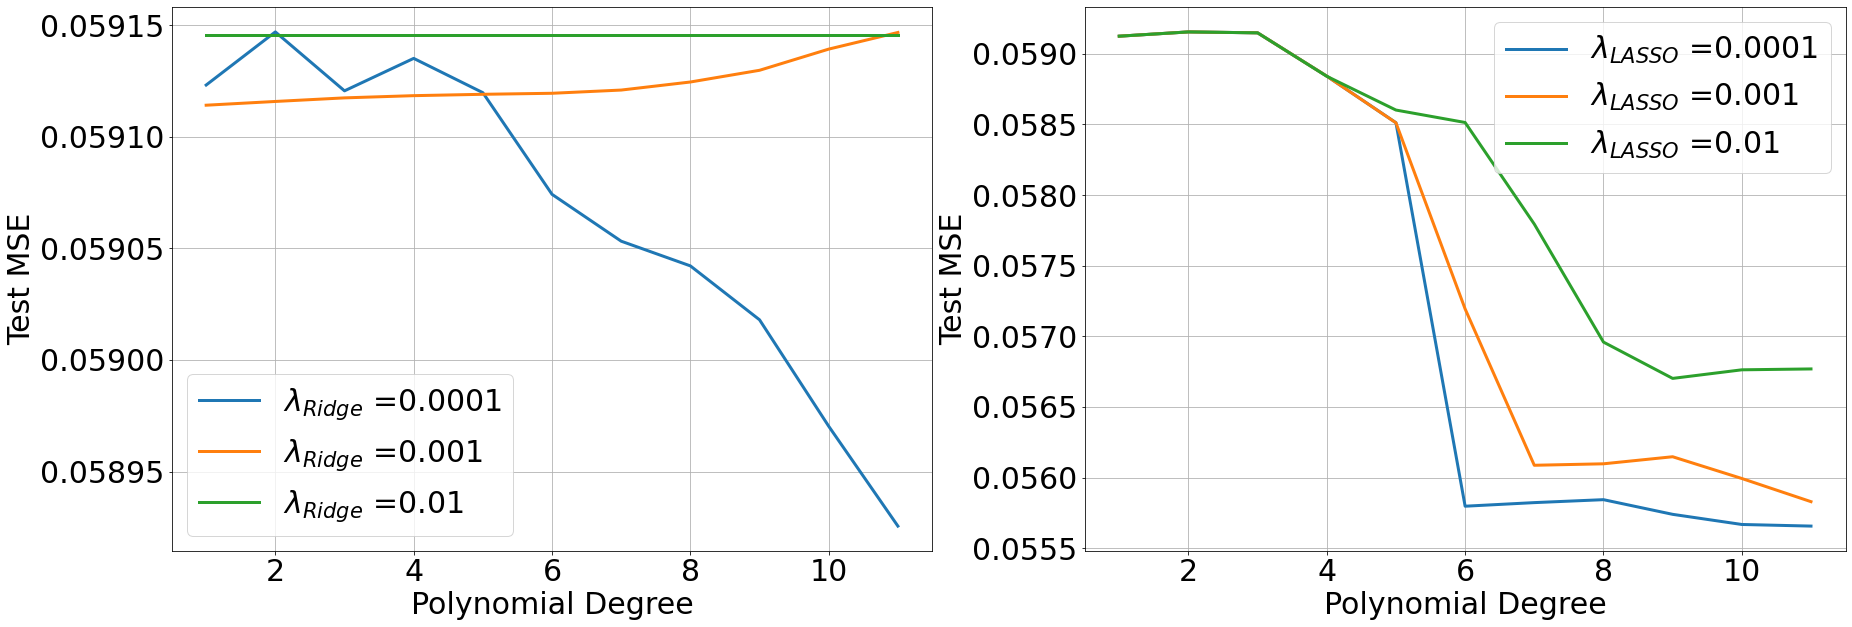

In [47]:
# Maximum polynomial order for generating the design matrix
maxpower = 15
k        = 5

np.random.seed(2020)
# subselecting the data, normalizing, creating x and y
terrain_n = terrain_data[200:300,1300:1400]

#normalizing data 
zz    = (terrain_n)/np.max(np.ravel(terrain_n))  
nx,ny = zz.shape

x = np.linspace(0, 1, nx)
np.random.shuffle(x)
y = np.linspace(0, 1, ny)
np.random.shuffle(y)

# Meshgrid x and y to create a surface
z = np.ravel(zz)

lambdas = np.logspace(-4,-2,3)  # try it wit (-8,-2,7)
kfold   = KFold(n_splits = k,shuffle=True,random_state=5)
scaler  = StandardScaler()

mse_ridge_in  = np.empty([maxpower, len(lambdas)])
mse_ridge_out = np.empty([maxpower, len(lambdas)])
mse_lasso_in  = np.empty([maxpower, len(lambdas)])
mse_lasso_out = np.empty([maxpower, len(lambdas)])

for power in range(maxpower):
    for lamb in range(len(lambdas)): 
        X            = fx.DesignDesign(x,y,power+1)
        errin_lasso  = 0
        errout_lasso = 0
        errin_ridge  = 0
        errout_ridge = 0

        for train, test in kfold.split(X):
            x_train = X[train]
            z_train = z[train]
            x_test  = X[test]
            z_test  = z[test]

            ## Scaling
            x_train_int = x_train[:,0]
            x_test_int  = x_test[:,0]
            x_train     = x_train[:,1:]
            x_test      = x_test[:,1:]
            scaler.fit(x_train)
            x_train = scaler.transform(x_train)
            x_test  = scaler.transform(x_test)
            x_train = np.c_[x_train_int,x_train]
            x_test  = np.c_[x_test_int,x_test]

            lasso     = Lasso(alpha=lambdas[lamb], fit_intercept=True, max_iter=10e4) # try it with 10e7
            fit_lasso = lasso.fit(x_train, z_train)
            _, predictRidge, predictRidge_train = fx.RidgeRegression(x_train,z_train,x_test,lambdas[lamb])
            
            predictLasso       = lasso.predict(x_test)
            predictLasso_train = lasso.predict(x_train)
            
            errin_lasso  += fx.MSE(z_train, predictLasso_train)
            errout_lasso += fx.MSE(z_test, predictLasso)
            errin_ridge  += fx.MSE(z_train, predictRidge_train)
            errout_ridge += fx.MSE(z_test, predictRidge)
            
        mse_lasso_in[power,lamb]  = errin_lasso/k
        mse_lasso_out[power,lamb] = errout_lasso/k
        mse_ridge_in[power,lamb]  = errin_ridge/k
        mse_ridge_out[power,lamb] = errout_ridge/k

fig = plt.subplots(figsize=(30,10))
ax = plt.subplot(1, 2, 1)
for i in range(np.shape(lambdas)[0]):
    pl=ax.plot(range(1,maxpower+1),mse_ridge_out[:,i], label='$\lambda_{Ridge}$ ='+str(lambdas[i]),linewidth=3)
    col=pl[0].get_color()   
plt.legend()
ax.legend(loc='lower left',fontsize=30)
plt.grid()
ax.tick_params(axis='both', which='major', labelsize=30)
plt.xlabel('Polynomial Degree', fontsize=30)
plt.ylabel('Test MSE', fontsize=30)


ax = plt.subplot(1, 2, 2)
for i in range(np.shape(lambdas)[0]):
    pl=ax.plot(range(1,maxpower+1),mse_lasso_out[:,i], label='$\lambda_{LASSO}$ ='+str(lambdas[i]),linestyle='-',linewidth=3)
    col=pl[0].get_color()   
plt.legend()
ax.legend(loc='upper right',fontsize=30)
plt.grid()
ax.tick_params(axis='both', which='major', labelsize=30)
plt.xlabel('Polynomial Degree', fontsize=30)
plt.ylabel('Test MSE', fontsize=30)
save_fig('Modelsel_Ridge_LASSO_scaled')
plt.show()


# Terrain data anlysis using OLS, Ridge, and LASSO (with optimal parameters)

Training MSE_OLS: 0.0002
Training MSE_Ridge: 0.0042
Training MSE_LASSO: 0.0243
Test MSE_OLS: 0.1124
Test MSE_Ridge: 0.1108
Test MSE_LASSO: 0.0721
Training R2_OLS: 0.9968
Training R2_Ridge: 0.9239
Training R2_LASSO: 0.5638
Test R2_OLS: -8.4478
Test R2_Ridge: -8.3161
Test R2_LASSO: -5.0626


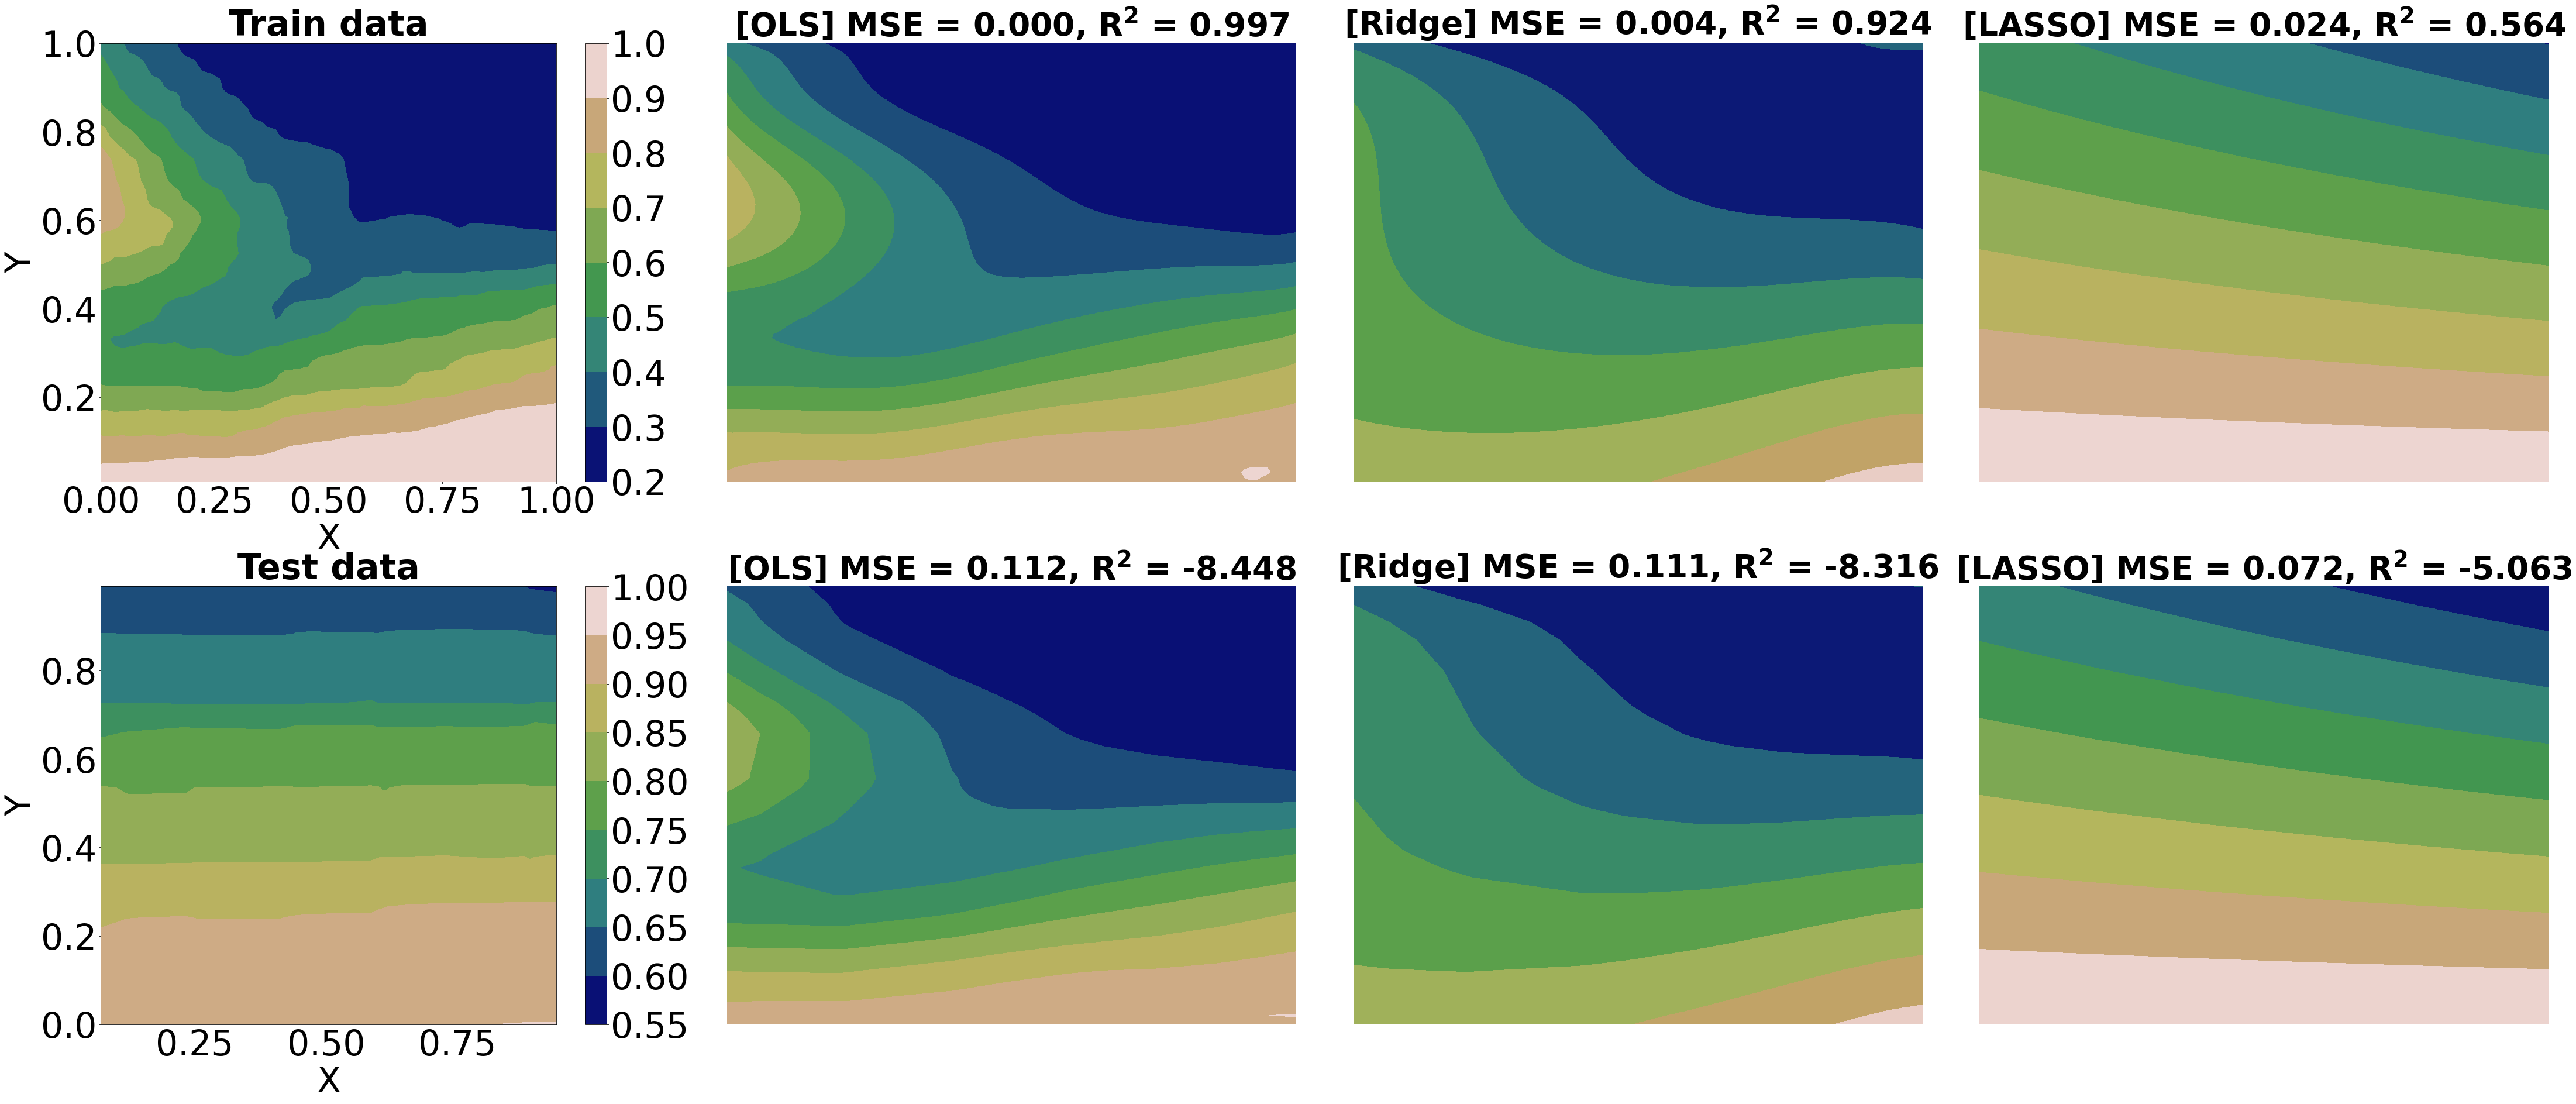

In [51]:
np.random.seed(2020)
# subselecting the data, normalizing, creating x and y
terrain_n = terrain_data[200:300,1300:1400]

#normalizing data 
terrain = (terrain_n)/np.max(np.ravel(terrain_n))  
nx,ny   = terrain.shape

x = np.linspace(0, 1, nx)
np.random.shuffle(x)
y = np.linspace(0, 1, ny)
np.random.shuffle(y)

# split in training and test data
nx_test  = int(0.2*nx)
ny_test  = int(0.2*ny)
nx_train = int(0.8*nx)
ny_train = int(0.8*ny)
x_test   = np.sort(x[:nx_test])
y_test   = np.sort(y[:ny_test])
x_train  = np.sort(x[nx_test:])
y_train  = np.sort(y[ny_test:])
x        = np.sort(x)
y        = np.sort(y)

# Meshgrid x and y to create a surface
xx_train, yy_train = np.meshgrid(x_train,y_train)
xx_test, yy_test   = np.meshgrid(x_test,y_test)

zz_train = np.zeros((nx_train,ny_train))
for ii in range(nx_train):
    for jj in range(ny_train):
        zz_train[ii,jj] = terrain[ii,jj]
        
zz_test = np.zeros((nx_test,ny_test))
for ii in range(nx_test):
    for jj in range(ny_test):
        zz_test[ii,jj] = terrain[ii,jj]
        
z_train  = np.ravel(zz_train)
z_test   = np.ravel(zz_test)

# Maximum polynomial order for generating the design matrix
degree_ols   = 6
degree_ridge = 6
degree_lasso = 8           
degreem      = 8

_lambda  = 1e-5
_lambda2 = 1e-5

# Creating design matrix, extracting beta and predicting 
X_train_ols   = fx.DesignDesign(x_train,y_train,degree_ols)  
X_test_ols    = fx.DesignDesign(x_test,y_test,degree_ols)  
X_train_ridge = fx.DesignDesign(x_train,y_train,degree_ridge)  
X_test_ridge  = fx.DesignDesign(x_test,y_test,degree_ridge)  
X_train_lasso = fx.DesignDesign(x_train,y_train,degree_lasso)  
X_test_lasso  = fx.DesignDesign(x_test,y_test,degree_lasso)  

## Scaling OLS
scaler          = StandardScaler()
X_train_int_ols = X_train_ols[:,0]
X_test_int_ols  = X_test_ols[:,0]
X_train_ols     = X_train_ols[:,1:]
X_test_ols      = X_test_ols[:,1:]
scaler.fit(X_train_ols)
X_train_ols = scaler.transform(X_train_ols)
X_test_ols  = scaler.transform(X_test_ols)
X_train_ols = np.c_[X_train_int_ols,X_train_ols]
X_test_ols  = np.c_[X_test_int_ols,X_test_ols]

## Scaling Ridge
X_train_int_ridge = X_train_ridge[:,0]
X_test_int_ridge  = X_test_ridge[:,0]
X_train_ridge     = X_train_ridge[:,1:]
X_test_ridge      = X_test_ridge[:,1:]
scaler.fit(X_train_ridge)
X_train_ridge = scaler.transform(X_train_ridge)
X_test_ridge  = scaler.transform(X_test_ridge)
X_train_ridge = np.c_[X_train_int_ridge,X_train_ridge]
X_test_ridge  = np.c_[X_test_int_ridge,X_test_ridge]

## Scaling OLS
X_train_int_lasso = X_train_lasso[:,0]
X_test_int_lasso  = X_test_lasso[:,0]
X_train_lasso     = X_train_lasso[:,1:]
X_test_lasso      = X_test_lasso[:,1:]
scaler.fit(X_train_lasso)
X_train_lasso = scaler.transform(X_train_lasso)
X_test_lasso  = scaler.transform(X_test_lasso)
X_train_lasso = np.c_[X_train_int_lasso,X_train_lasso]
X_test_lasso  = np.c_[X_test_int_lasso,X_test_lasso]

# OLS
_, pred_OLS_test, pred_OLS_train = fx.OridinaryLeastSquares(X_train_ols,z_train,X_test_ols) 

# Ridge
_, pred_Ridge_test, pred_Ridge_train = fx.RidgeRegression(X_train_ridge,z_train,X_test_ridge,_lambda) 

# LASSO
lasso      = Lasso(alpha = _lambda2, max_iter=10e6, fit_intercept=False)
clf_lasso  = lasso.fit(X_train_lasso, z_train) 

pred_LASSO_test  = lasso.predict(X_test_lasso)
pred_LASSO_train = lasso.predict(X_train_lasso)

# MSE and R2
MSE_OLS_test  = fx.MSE(z_test,pred_OLS_test)
MSE_OLS_train = fx.MSE(z_train,pred_OLS_train)
R2_OLS_test   = fx.R2Score(z_test,pred_OLS_test)
R2_OLS_train  = fx.R2Score(z_train,pred_OLS_train)
    
MSE_Ridge_test  = fx.MSE(z_test,pred_Ridge_test)
MSE_Ridge_train = fx.MSE(z_train,pred_Ridge_train)
R2_Ridge_test   = fx.R2Score(z_test,pred_Ridge_test)
R2_Ridge_train  = fx.R2Score(z_train,pred_Ridge_train)

MSE_LASSO_test  = fx.MSE(z_test,pred_LASSO_test)
MSE_LASSO_train = fx.MSE(z_train,pred_LASSO_train)
R2_LASSO_test   = fx.R2Score(z_test,pred_LASSO_test)
R2_LASSO_train  = fx.R2Score(z_train,pred_LASSO_train)
        
# Plot the resulting fit beside the original surface
ppred_OLS_test  = pred_OLS_test.reshape(xx_test.shape)
ppred_OLS_train = pred_OLS_train.reshape(xx_train.shape)

ppred_Ridge_test  = pred_Ridge_test.reshape(xx_test.shape)
ppred_Ridge_train = pred_Ridge_train.reshape(xx_train.shape)        

ppred_LASSO_test  = pred_LASSO_test.reshape(xx_test.shape)
ppred_LASSO_train = pred_LASSO_train.reshape(xx_train.shape)

print("Training MSE_OLS: %0.4f" % MSE_OLS_train)
print("Training MSE_Ridge: %0.4f" % MSE_Ridge_train)
print("Training MSE_LASSO: %0.4f" % MSE_LASSO_train)

print("Test MSE_OLS: %0.4f" % MSE_OLS_test)
print("Test MSE_Ridge: %0.4f" % MSE_Ridge_test)
print("Test MSE_LASSO: %0.4f" % MSE_LASSO_test)

print("Training R2_OLS: %0.4f" % R2_OLS_train)
print("Training R2_Ridge: %0.4f" % R2_Ridge_train)
print("Training R2_LASSO: %0.4f" % R2_LASSO_train)

print("Test R2_OLS: %0.4f" % R2_OLS_test)
print("Test R2_Ridge: %0.4f" % R2_Ridge_test)
print("Test R2_LASSO: %0.4f" % R2_LASSO_test)

########################### Plotting subselected data #############################

fig  = plt.figure(figsize=(75, 65))
ax =plt.subplot(4, 4, 1)
figure1=plt.contourf(x_train,y_train,zz_train, cmap='gist_earth')
plt.title('Train data', fontsize=60, fontweight='bold')
plt.xlabel('X', fontsize=60)
plt.ylabel('Y', fontsize=60)
ax.tick_params(axis='both', which='major', labelsize=60)
cbar=fig.colorbar(figure1)
cbar.ax.tick_params(labelsize=60)
#fig.tight_layout()
plt.subplots_adjust(wspace =0.1, hspace =0.24)

ax=plt.subplot(4, 4, 2)
figure2=plt.contourf(x_train,y_train,ppred_OLS_train, cmap='gist_earth')
plt.title("[OLS]"+" MSE = %0.3f" %MSE_OLS_train + 
          r", $\bf{R^2}$ = %0.3f"%R2_OLS_train, fontsize = 55, fontweight='bold')
plt.xlabel('X', fontsize=55)
plt.ylabel('Y', fontsize=55)
ax.tick_params(axis='both', which='major', labelsize=45)
#fig.tight_layout()
plt.axis('off')

ax=plt.subplot(4, 4, 3)
figure3=plt.contourf(x_train,y_train,ppred_Ridge_train, cmap='gist_earth')
plt.title("[Ridge]"+" MSE = %0.3f" %MSE_Ridge_train + 
          r", $\bf{R^2}$ = %0.3f"%R2_Ridge_train, fontsize = 55, fontweight='bold')
plt.xlabel('X', fontsize=55)
plt.ylabel('Y', fontsize=55)
ax.tick_params(axis='both', which='major', labelsize=45)
#fig.tight_layout()
plt.axis('off')

ax=plt.subplot(4, 4, 4)
figure4=plt.contourf(x_train,y_train,ppred_LASSO_train, cmap='gist_earth')
plt.title("[LASSO]"+" MSE = %0.3f" %MSE_LASSO_train + 
          r", $\bf{R^2}$ = %0.3f"%R2_LASSO_train, fontsize = 55, fontweight='bold')
plt.xlabel('X', fontsize=55)
plt.ylabel('Y', fontsize=55)
ax.tick_params(axis='both', which='major', labelsize=45)
#fig.tight_layout()
plt.axis('off')

#plt.subplots(figsize=(15, 5))
ax = plt.subplot(4, 4, 5)
figure3=plt.contourf(x_test,y_test,zz_test, cmap='gist_earth')
plt.title('Test data', fontsize=60, fontweight='bold')
plt.xlabel('X', fontsize=60)
plt.ylabel('Y', fontsize=60)
ax.tick_params(axis='both', which='major', labelsize=60)
cbar=fig.colorbar(figure3)
cbar.ax.tick_params(labelsize=60)
#fig.tight_layout()
#plt.axis('off')

ax=plt.subplot(4, 4, 6)
figure4=plt.contourf(x_test,y_test,ppred_OLS_test, cmap='gist_earth')
plt.title("[OLS]"+" MSE = %0.3f" %MSE_OLS_test + 
          r", $\bf{R^2}$ = %0.3f"%R2_OLS_test, fontsize = 55, fontweight='bold')
plt.xlabel('X', fontsize=55)
plt.ylabel('Y', fontsize=55)
ax.tick_params(axis='both', which='major', labelsize=45)
#fig.tight_layout()
plt.axis('off')

ax=plt.subplot(4, 4, 7)
figure4=plt.contourf(x_test,y_test,ppred_Ridge_test, cmap='gist_earth')
plt.title("[Ridge]"+" MSE = %0.3f" %MSE_Ridge_test + 
          r", $\bf{R^2}$ = %0.3f"%R2_Ridge_test, fontsize = 55, fontweight='bold')
plt.xlabel('X', fontsize=55)
plt.ylabel('Y', fontsize=55)
ax.tick_params(axis='both', which='major', labelsize=45)
#fig.tight_layout()
plt.axis('off')

ax=plt.subplot(4, 4, 8)
figure4=plt.contourf(x_test,y_test,ppred_LASSO_test, cmap='gist_earth')
plt.title("[LASSO]"+" MSE = %0.3f" %MSE_LASSO_test + 
          r", $\bf{R^2}$ = %0.3f"%R2_LASSO_test, fontsize = 55, fontweight='bold')
plt.xlabel('X', fontsize=55)
plt.ylabel('Y', fontsize=55)
ax.tick_params(axis='both', which='major', labelsize=45)
#fig.tight_layout()
plt.axis('off')
save_fig('OLS_Ridge_LASSO')
plt.show()

# Confidence Interval

NameError: name 'beta_lasso' is not defined

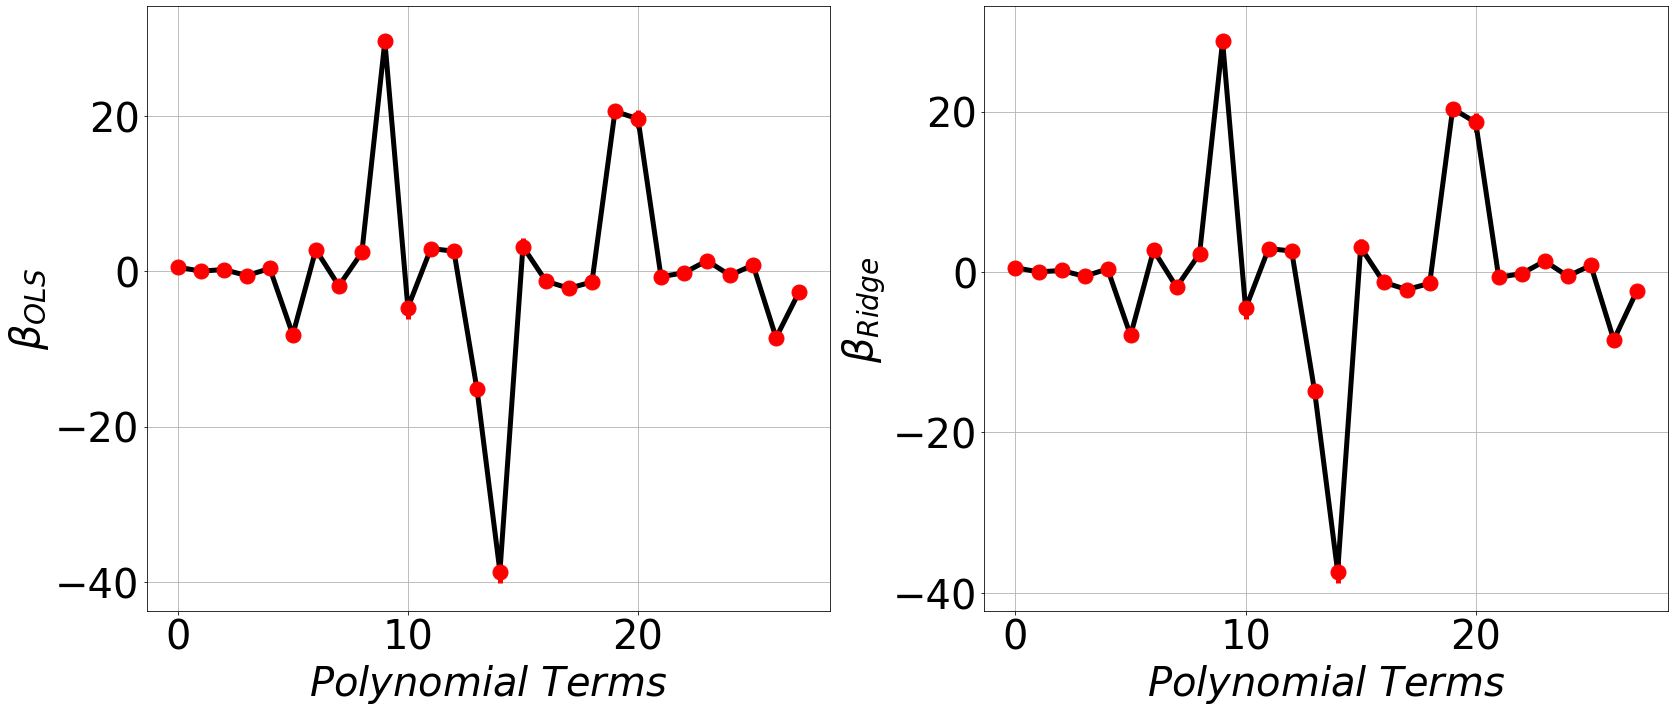

In [4]:
np.random.seed(2020)
# subselecting the data, normalizing, creating x and y
terrain_n = terrain_data[200:300,1300:1400]

#normalizing data 
terrain = (terrain_n)/np.max(np.ravel(terrain_n))  
nx,ny   = terrain.shape

x = np.linspace(0, 1, nx)
np.random.shuffle(x)
y = np.linspace(0, 1, ny)
np.random.shuffle(y)

# split in training and test data
nx_test  = int(0.2*nx)
ny_test  = int(0.2*ny)
nx_train = int(0.8*nx)
ny_train = int(0.8*ny)
x_test   = np.sort(x[:nx_test])
y_test   = np.sort(y[:ny_test])
x_train  = np.sort(x[nx_test:])
y_train  = np.sort(y[ny_test:])
x        = np.sort(x)
y        = np.sort(y)

# Meshgrid x and y to create a surface
xx_train, yy_train = np.meshgrid(x_train,y_train)
xx_test, yy_test   = np.meshgrid(x_test,y_test)

zz_train = np.zeros((nx_train,ny_train))
for ii in range(nx_train):
    for jj in range(ny_train):
        zz_train[ii,jj] = terrain[ii,jj]
        
zz_test = np.zeros((nx_test,ny_test))
for ii in range(nx_test):
    for jj in range(ny_test):
        zz_test[ii,jj] = terrain[ii,jj]
        
z_train  = np.ravel(zz_train)
z_test   = np.ravel(zz_test)

# Maximum polynomial order for generating the design matrix
degree_ols   = 6
degree_ridge = 6
degree_lasso = 8           
degreem      = 8

_lambda  = 1e-5
_lambda2 = 1e-5

# Creating design matrix, extracting beta and predicting 
X_train_ols   = fx.DesignDesign(x_train,y_train,degree_ols)  
X_test_ols    = fx.DesignDesign(x_test,y_test,degree_ols)  
X_train_ridge = fx.DesignDesign(x_train,y_train,degree_ridge)  
X_test_ridge  = fx.DesignDesign(x_test,y_test,degree_ridge)  
X_train_lasso = fx.DesignDesign(x_train,y_train,degree_lasso)  
X_test_lasso  = fx.DesignDesign(x_test,y_test,degree_lasso)  

## Scaling OLS
scaler          = StandardScaler()
X_train_int_ols = X_train_ols[:,0]
X_test_int_ols  = X_test_ols[:,0]
X_train_ols     = X_train_ols[:,1:]
X_test_ols      = X_test_ols[:,1:]
scaler.fit(X_train_ols)
X_train_ols = scaler.transform(X_train_ols)
X_test_ols  = scaler.transform(X_test_ols)
X_train_ols = np.c_[X_train_int_ols,X_train_ols]
X_test_ols  = np.c_[X_test_int_ols,X_test_ols]

## Scaling Ridge
X_train_int_ridge = X_train_ridge[:,0]
X_test_int_ridge  = X_test_ridge[:,0]
X_train_ridge     = X_train_ridge[:,1:]
X_test_ridge      = X_test_ridge[:,1:]
scaler.fit(X_train_ridge)
X_train_ridge = scaler.transform(X_train_ridge)
X_test_ridge  = scaler.transform(X_test_ridge)
X_train_ridge = np.c_[X_train_int_ridge,X_train_ridge]
X_test_ridge  = np.c_[X_test_int_ridge,X_test_ridge]

## Scaling LASSO
X_train_int_lasso = X_train_lasso[:,0]
X_test_int_lasso  = X_test_lasso[:,0]
X_train_lasso     = X_train_lasso[:,1:]
X_test_lasso      = X_test_lasso[:,1:]
scaler.fit(X_train_lasso)
X_train_lasso = scaler.transform(X_train_lasso)
X_test_lasso  = scaler.transform(X_test_lasso)
X_train_lasso = np.c_[X_train_int_lasso,X_train_lasso]
X_test_lasso  = np.c_[X_test_int_lasso,X_test_lasso]

# OLS
beta_OLS, pred_OLS_test, pred_OLS_train = fx.OridinaryLeastSquares(X_train_ols,z_train,X_test_ols) 

# confidence interval OLS
Var_beta_OLS, conf_OLS = fx.VarianceBeta_OLS(X_train_ols,z_train,pred_OLS_train)

# Ridge
beta_Ridge, pred_Ridge_test, pred_Ridge_train = fx.RidgeRegression(X_train_ridge,z_train,X_test_ridge,_lambda) 

# confidence interval Ridge
Var_beta_Ridge, conf_Ridge = fx.VarianceBeta_Ridge(X_train_ridge,z_train,pred_Ridge_train,_lambda)

# LASSO
lasso      = Lasso(alpha = _lambda2, max_iter=10e6, fit_intercept=False)
clf_lasso  = lasso.fit(X_train_lasso, z_train) 
beta_LASSO = clf_lasso.coef_
beta_LASSO = beta_LASSO.reshape(X_train_lasso.shape[1],1)

pred_LASSO_test  = lasso.predict(X_test_lasso)
pred_LASSO_train = lasso.predict(X_train_lasso)

#---------------------- Bootstrap to calculate confidence interval of LASSO --------------

n_boostraps  = int(nx)
beta_LASSOb  = np.empty((X_train_lasso.shape[1], n_boostraps))

for i in range(n_boostraps):
    
    X_, z_            = resample(X_train_lasso, z_train)
    clf_lassob        = lasso.fit(X_, z_) 
    beta_LASSOb[:, i] = clf_lassob.coef_

varbeta    = np.var(beta_LASSOb, axis=1, keepdims=True)
meanbeta   = np.mean(beta_LASSOb, axis=1, keepdims=True)
conf_LASSO = 1.96*np.sqrt(varbeta)

########################### Plotting subselected data #############################

xax_ols = np.arange(0, len(beta_OLS), 1) 
fig = plt.figure(figsize=(35, 10))
ax = plt.subplot(1, 3, 1) 
plt.plot(xax_ols, beta_OLS, 'k',linewidth=5)
plt.errorbar(xax_ols, beta_OLS, yerr = conf_OLS, fmt='or',markersize=15,linewidth=5) 
plt.xlabel("$Polynomial$ $Terms$", fontsize = 40)
plt.ylabel(r"$\beta_{OLS}$", fontsize = 40)
ax.tick_params(axis='both', which='major', labelsize=40)
plt.grid()
fig.tight_layout()

xax_ridge = np.arange(0, len(beta_Ridge), 1) 
ax = plt.subplot(1, 3, 2)
plt.plot(xax_ridge, beta_Ridge, 'k',linewidth=5)
plt.errorbar(xax_ridge, beta_Ridge, yerr = conf_Ridge, fmt='or',markersize=15,linewidth=5) 
plt.xlabel("$Polynomial$ $Terms$", fontsize = 40)
plt.ylabel(r"$\beta_{Ridge}$", fontsize = 40)
ax.tick_params(axis='both', which='major', labelsize=40)
plt.grid()
fig.tight_layout()

xax_lasso = np.arange(0, len(beta_LASSO), 1) 
ax = plt.subplot(1, 3, 3) 
plt.plot(xax_lasso, beta_LASSO, 'k',linewidth=5)
plt.errorbar(xax_lasso, beta_LASSO, conf_LASSO.reshape(-1,1), fmt='or',markersize=15,linewidth=5) 
plt.xlabel("$Polynomial$ $Terms$", fontsize = 40)
plt.ylabel(r"$\beta_{LASSO}$", fontsize = 40)
ax.tick_params(axis='both', which='major', labelsize=40)
plt.grid()
fig.tight_layout()
save_fig('Confidence_interval_scaled')
plt.show()